Circuito de Toffoli Descompuesto:


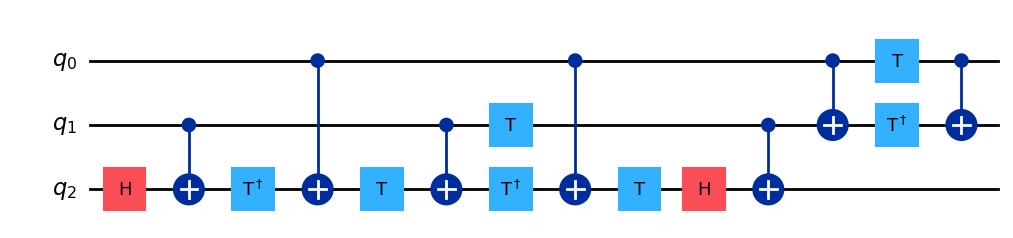

Circuito OR Cuántico:


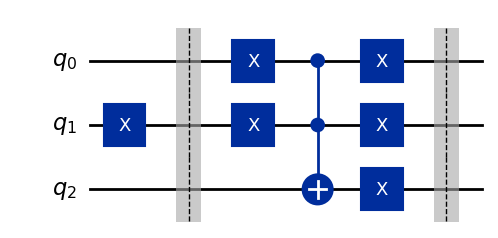

Circuito de Computación Limpia (Uncomputing):


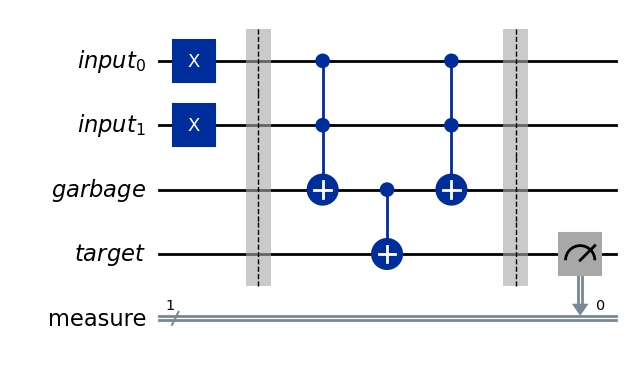

Resultados (Target): {'1': 1024}


In [1]:
# %% [markdown]
# # Fundamentos Algorítmicos Cuánticos
# Este notebook implementa las construcciones fundamentales descritas en la Lección 6.
# Cubriremos:
# 1. Descomposición de la puerta Toffoli.
# 2. Simulación de compuertas lógicas clásicas (AND, OR, FANOUT).
# 3. Construcción de oráculos limpios mediante "Uncomputing".

# %%
# 1. Importaciones y Configuración
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Simulador
sim = AerSimulator()

# %% [markdown]
# ## 1. La Puerta Toffoli y su Descomposición
# La puerta Toffoli (CCNOT) es esencial para la computación clásica reversible.
# Sin embargo, en hardware cuántico real, a menudo debe descomponerse en puertas de 1 y 2 qubits.
# Referencia: Diapositiva 26.

# %%
def toffoli_decomposed():
    """
    Implementación de la descomposición de Toffoli usando H, T, Tdg y CNOT.
    """
    qc = QuantumCircuit(3)
    
    # Entradas (q0, q1 controles; q2 objetivo)
    # Aplicamos la secuencia exacta de la diapositiva 26
    
    qc.h(2)
    qc.cx(1, 2)
    qc.tdg(2)
    qc.cx(0, 2)
    qc.t(2)
    qc.cx(1, 2)
    qc.tdg(2)
    qc.cx(0, 2)
    qc.t(1)
    qc.t(2)
    qc.h(2)
    qc.cx(1, 2) # Nota: En algunas descomposiciones hay variaciones, seguimos la visual standard
    qc.cx(0, 1)
    qc.t(0)
    qc.tdg(1)
    qc.cx(0, 1)
    
    return qc

print("Circuito de Toffoli Descompuesto:")
qc_toffoli = toffoli_decomposed()
display(qc_toffoli.draw(output="mpl"))

# Nota: Qiskit tiene su propia descomposición interna, pero esta es la construcción teórica clásica.

# %% [markdown]
# ## 2. Simulación de Compuertas Booleanas
# Las computadoras cuánticas deben ser reversibles. Aquí implementamos las compuertas clásicas básicas.
# Referencia: Diapositivas 27 y 28.

# %%
# --- COMPUERTA AND ---
# Se simula directamente con una Toffoli.
# |a>|b>|0> -> |a>|b>|a AND b>

def quantum_and():
    qc = QuantumCircuit(3)
    # Ejemplo: 1 AND 1 = 1
    qc.x(0) # a = 1
    qc.x(1) # b = 1
    
    qc.barrier()
    qc.ccx(0, 1, 2) # Toffoli actúa como AND
    qc.barrier()
    
    return qc

# --- COMPUERTA OR ---
# Se simula usando leyes de De Morgan con Toffoli y NOTs.
# A OR B = NOT( (NOT A) AND (NOT B) )

def quantum_or():
    qc = QuantumCircuit(3)
    # Ejemplo: 0 OR 1 = 1
    qc.x(1) # b = 1
    
    qc.barrier()
    # 1. Invertir entradas
    qc.x(0)
    qc.x(1)
    
    # 2. Toffoli (AND de los negados)
    qc.ccx(0, 1, 2)
    
    # 3. Invertir resultado (para obtener OR)
    qc.x(2)
    
    # 4. Restaurar entradas (Reversibilidad)
    qc.x(0)
    qc.x(1)
    qc.barrier()
    
    return qc

# --- COMPUERTA FANOUT (Copia) ---
# Se simula con una CNOT.
# Copia el estado de control al objetivo (si objetivo es |0>).

def quantum_fanout():
    qc = QuantumCircuit(2)
    qc.x(0) # Dato a copiar
    
    qc.barrier()
    qc.cx(0, 1) # CNOT actúa como COPY
    qc.barrier()
    
    return qc

print("Circuito OR Cuántico:")
display(quantum_or().draw(output="mpl"))

# %% [markdown]
# ## 3. Computación Limpia (Uncomputing)
# Cuando usamos compuertas auxiliares (ancillas) para calcular una función f(x), generamos "basura" (garbage) g(x).
# Para usar algoritmos cuánticos (interferencia), debemos limpiar esta basura.
# El patrón es: Calcular (R) -> Copiar resultado -> Descalcular (R_dagger).
# Referencia: Diapositivas 29 y 30.

# %%
def clean_computation_demo():
    """
    Demostración del patrón Compute-Copy-Uncompute.
    Calcularemos f(a,b,c) = (a AND b)
    Usaremos 'c' como ancilla para el cálculo intermedio.
    Guardaremos el resultado final en 'target'.
    """
    # Registros: 2 input, 1 ancilla (basura), 1 target
    inputs = QuantumRegister(2, 'input')
    ancilla = QuantumRegister(1, 'garbage')
    target = QuantumRegister(1, 'target')
    cr = ClassicalRegister(1, 'measure')
    
    qc = QuantumCircuit(inputs, ancilla, target, cr)
    
    # Entrada: |11>
    qc.x(inputs[0])
    qc.x(inputs[1])
    
    qc.barrier()
    
    # --- PASO 1: COMPUTAR (R) ---
    # Calculamos (a AND b) y lo guardamos en la ancilla
    qc.ccx(inputs[0], inputs[1], ancilla[0])
    
    # --- PASO 2: COPIAR (X) ---
    # Copiamos el resultado de la ancilla al target usando CNOT
    qc.cx(ancilla[0], target[0])
    
    # --- PASO 3: DESCOMPUTAR (R dagger) ---
    # Aplicamos la inversa de R para limpiar la ancilla.
    # Para Toffoli, su inversa es ella misma.
    qc.ccx(inputs[0], inputs[1], ancilla[0])
    
    qc.barrier()
    
    # Medimos solo el target. 
    # Si lo hicimos bien, la ancilla debería volver a 0 (no afectando el estado global)
    qc.measure(target, cr)
    
    return qc

qc_clean = clean_computation_demo()
print("Circuito de Computación Limpia (Uncomputing):")
display(qc_clean.draw(output="mpl"))

# Ejecución
result = sim.run(qc_clean, shots=1024).result()
counts = result.get_counts()
print(f"Resultados (Target): {counts}")
# Deberíamos obtener '1' (porque 1 AND 1 = 1) y la ancilla implícitamente limpia.